In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
import sys
import os
import glob
import shutil

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
device, kwargs, torch.__version__, sys.version

(device(type='cuda'),
 {'num_workers': 2, 'pin_memory': True},
 '1.4.0',
 '3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]')

In [4]:
files = glob.glob("TEMP/CC/*")
# files

In [5]:
x = Image.open(files[233])

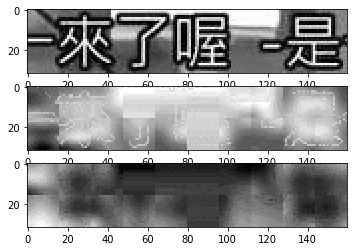

In [6]:
def normalize(x):
    x = x.convert("YCbCr")
    im = np.array(x, dtype=np.float)
    a = -0.5
    b = 0.5
    y = np.zeros([im.shape[2], im.shape[0], im.shape[1]], dtype=np.float)
    for i in range(3):
        minimum = np.min(im[:,:,i])
        maximum = np.max(im[:,:,i])
        delta = max(maximum - minimum, 0.01)
        y[i,:,:] = a + ((im[:,:,i] - minimum) * (b - a)) / delta
        # print(minimum, maximum)
    return y

im = normalize(x)

plt.subplots(3, 1)
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.imshow(im[i,:,:], cmap='gray')

In [7]:
np.max(im[1,:,:])

0.5

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.50),
        )
        self.mlp = nn.Sequential(
            nn.Linear(64064, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
        )
        self.optimizer = optim.Adam(self.parameters())
        self.loss = None

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1, 64064)
        x = self.mlp(x)
        return x

    def train_data(self, data, target):
        self.optimizer.zero_grad()
        output = self.forward(data)
        self.loss = nn.functional.binary_cross_entropy_with_logits(output, target)
        self.loss.backward()
        self.optimizer.step()

model = Net().to(device)
model

Net(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=64064, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [9]:
MODEL_NAME = "model.mdl"
if os.path.isfile(MODEL_NAME):
    print(MODEL_NAME)
    model.load_state_dict(torch.load(MODEL_NAME))

model.mdl


In [10]:
im.shape

(3, 32, 160)

In [11]:
x = torch.randn(64, 3, 32, 160).to(device)
y = model.forward(x)

In [12]:
def predictModel(model, test):
    model.eval()
    with torch.no_grad():
        testX = torch.from_numpy(test).float().to(device)
        predict = model(testX).cpu()
    predict = np.where(predict > 0, 1, 0)
    return predict

In [13]:
# read training data
ccfiles = glob.glob("TEMP/CC/*.jpg")
n = len(ccfiles)
n

8740

In [14]:
def classified(files):
    n = len(files)
    test = np.zeros((n, 3, 32, 160), dtype=np.float)
    for i in range(n):
        fname = files[i]
        test[i, :, :, :] = normalize(Image.open(fname))
        
    y = predictModel(model, test)
    
    for i in range(n):
        fname = files[i]
        if y[i] == 1:
            outfile = fname.replace('CC\\', 'CC1\\')
            shutil.copyfile(fname, outfile)


M = (n + 1023) // 1024
for i in range(M):
    if i == M-1:
        files = ccfiles[i*1024:]
    else:
        files = ccfiles[i*1024:(i+1)*1024]

    classified(files)

In [15]:
ccfiles = glob.glob("TEMP/CC1/*.jpg")
n = len(ccfiles)
n

2454

In [16]:
def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

for i in range(n-1):
    fname = ccfiles[i]
    x1 = Image.open(ccfiles[i])
    x2 = Image.open(ccfiles[i+1])
    x = get_concat_v(x1, x2)
    outfile = fname.replace('CC1\\', 'CC2\\')
    x.save(outfile)

In [17]:
ccfiles[0]

'TEMP/CC1\\frame000004.jpg'